In [46]:
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

# Data_Normal.csv

## הצגת הנתונים


In [2]:
data_normal = pd.read_csv('Data_Normal.csv')
print(data_normal)

               0
0       4.601843
1      29.160211
2      45.282606
3      21.048532
4      35.830229
..           ...
995  2005.417263
996  2014.131368
997  1990.444198
998  2017.585496
999  1987.905858

[1000 rows x 1 columns]


<div style="text-align: right"> ובאופן גרפי: </div>

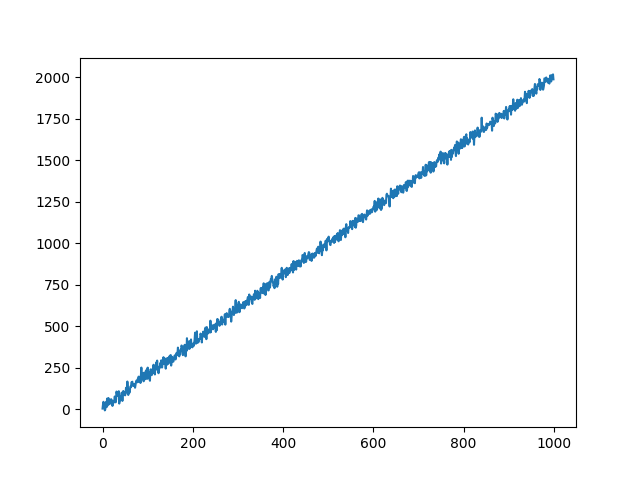

In [3]:
%matplotlib widget
plt.close()
plt.plot(data_normal)
plt.show()

## סטציונריות


ראשית נבדוק אם הנתונים האלה סטציונריים ע"י מבחן adf:

In [4]:
result = adfuller(data_normal['0'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.291275
p-value: 0.976941
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


במילים אחרות, באופן לא מפתיע, הנתונים מאוד לא סטציונריים.
ננסה להסתכל בהפרשים, ולבדוק האם הם סטציונריים.

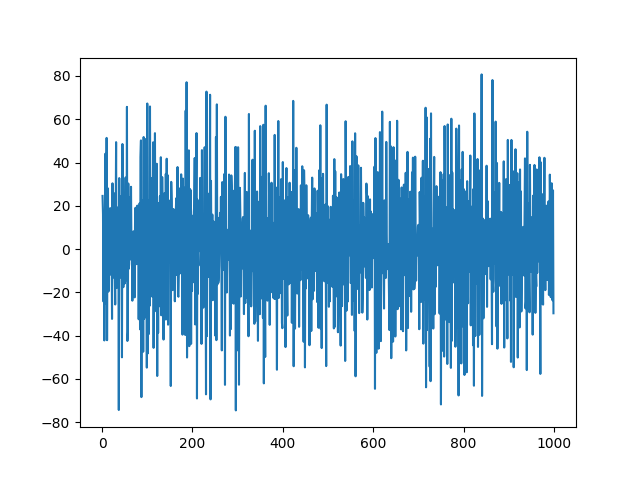

In [5]:
%matplotlib widget
data_normal_differencing = data_normal.diff()
plt.close()
plt.plot(data_normal_differencing)
plt.show()

האם זה סטציונרי?:

In [6]:
result = adfuller(data_normal_differencing.dropna()['0'].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -12.526195
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


כן.

## סטטיסטיקות וניתוח ראשוני


### סטטיסטיקות

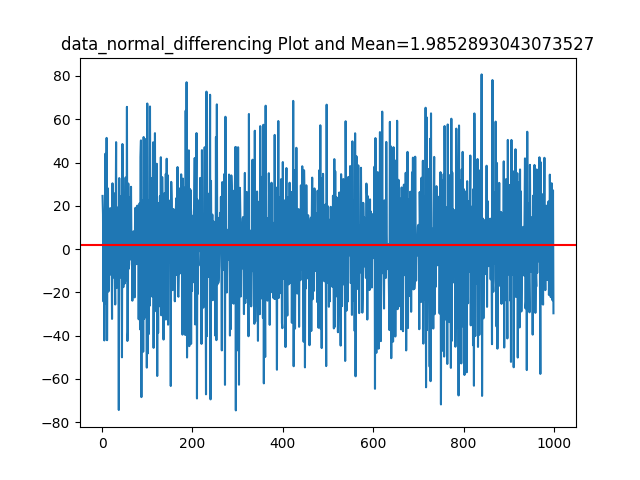

In [7]:
%matplotlib widget
plt.close()
plt.plot(data_normal_differencing)
plt.axhline(y=data_normal_differencing['0'].mean(), color='red')
plt.title(f'data_normal_differencing Plot and Mean={data_normal_differencing['0'].mean()}')
plt.show()

Using matplotlib backend: module://ipympl.backend_nbagg


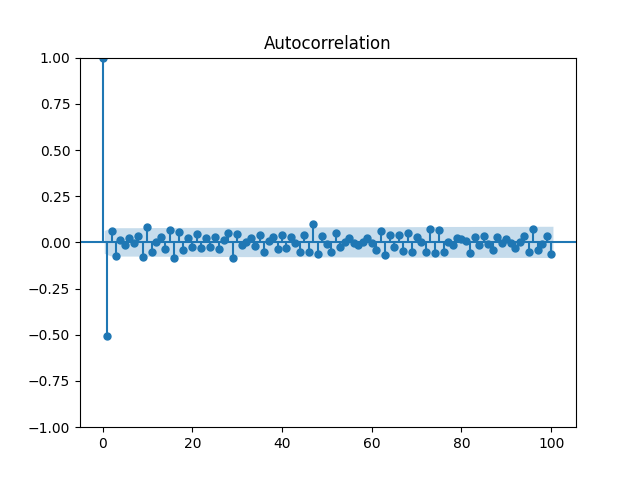

In [8]:
%matplotlib 
plt.close()
tsaplots.plot_acf(data_normal_differencing.dropna(), lags=100)
plt.show()

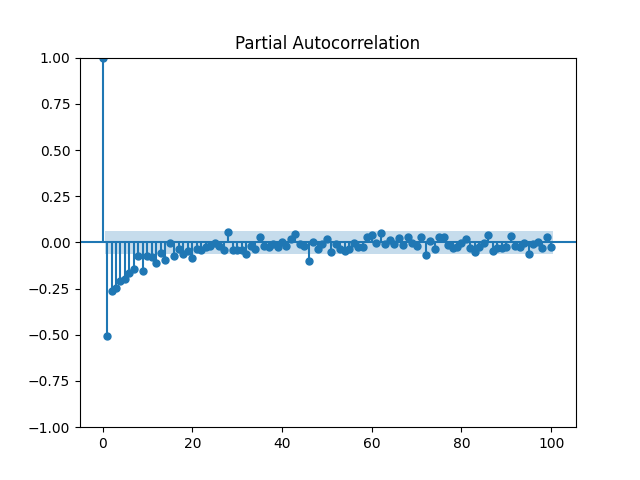

In [9]:
%matplotlib widget
plt.close()
tsaplots.plot_pacf(data_normal_differencing.dropna(), lags=100)
plt.show()

### ניתוח ראשוני

ראשית, ברור שסדרת ההפרשים היא לא רעש לבן, זאת מפני שבערך שבעת הערכים הראשונים של פונקציית האוטוקורולציה החלקית רחוקות משמעותית מאפס, כלומר התצפיות השונות בסדרה קורולטיביות.

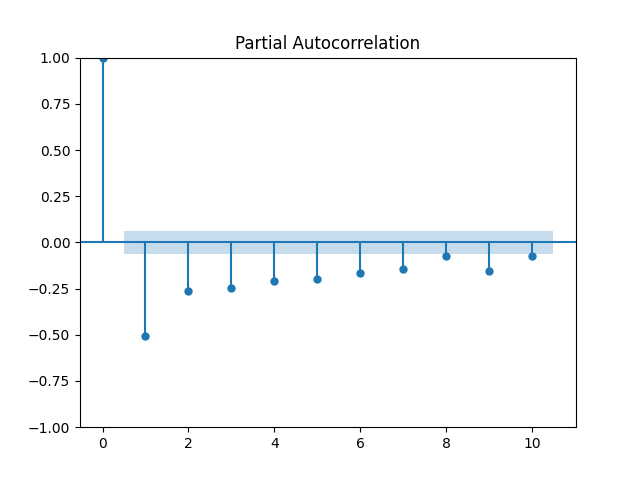

In [10]:
%matplotlib widget
plt.close()
tsaplots.plot_pacf(data_normal_differencing.dropna(), lags=10)
plt.show()

ניכר ששבעת הלאגים הראשונים הם משמעותיים סטטיסטית. ננסה למדל את סדרת ההפרשים כאוטורגרסיה(7).

C:\PythonProjects\AdmissionTest\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


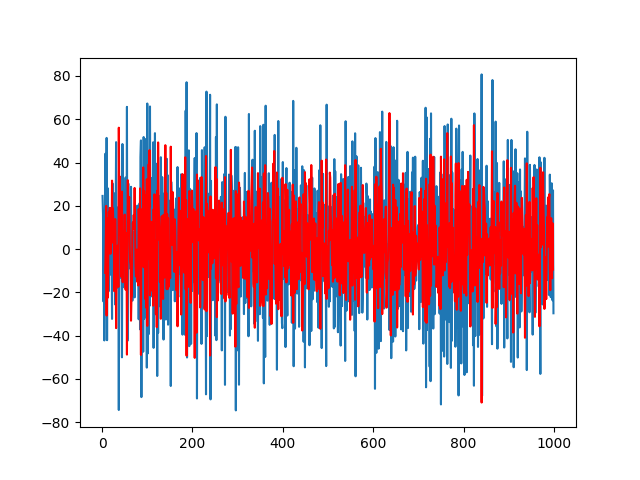

In [72]:
%matplotlib widget
ar_model = AutoReg(data_normal_differencing.dropna(), lags=7).fit()
prediction = ar_model.predict()
plt.close()
plt.plot(data_normal_differencing)
plt.plot(prediction, color='red')
plt.show()

נבדוק את ההפרש:

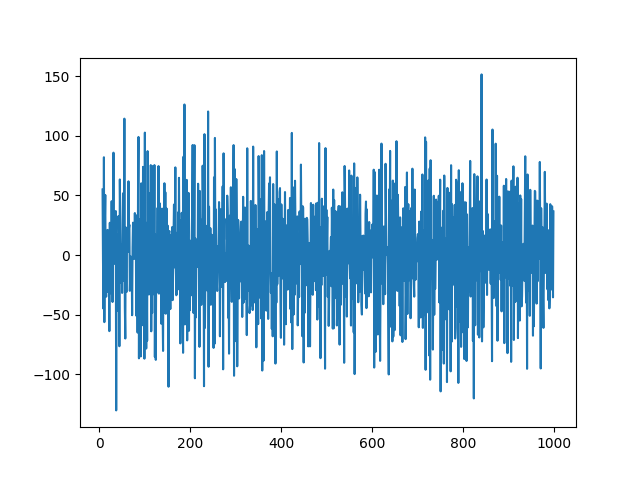

In [12]:
%matplotlib widget
plt.close()
noise = data_normal_differencing['0'] - prediction
plt.plot(noise)
plt.show()

ונבדוק שזה באמת רעש:

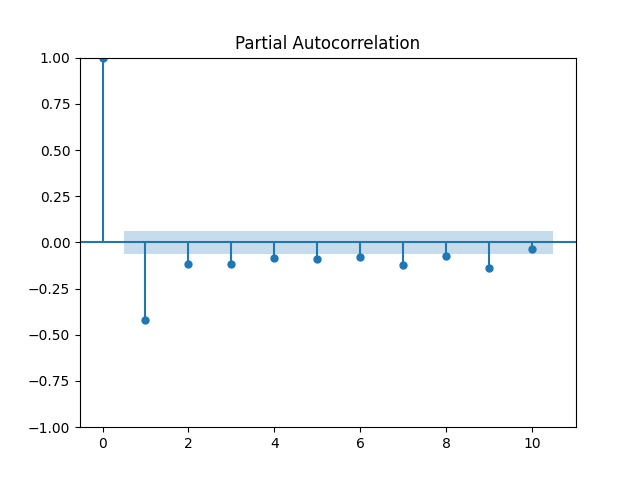

In [13]:
%matplotlib widget
plt.close()
tsaplots.plot_pacf(noise.dropna(), lags=10)
plt.show()

כלומר זה עדיין לא רעש לבן, למרות שהצלחנו להסיר את רוב האוטוקורלוציות החלקיות מלבד הלאג הראשון.
ננסה להשתמש במקום באוטו-ארימה:

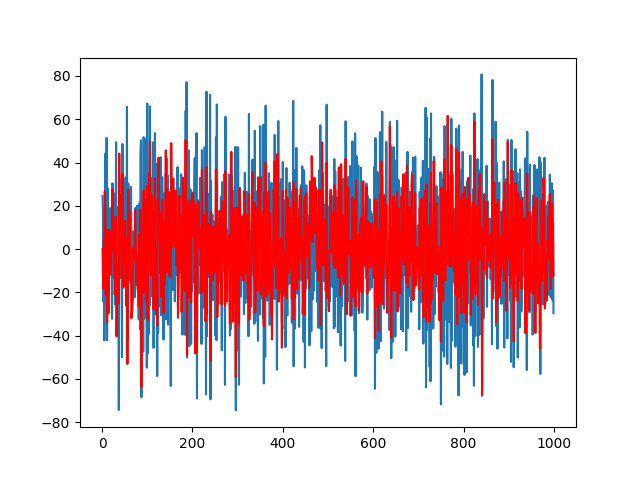

In [14]:
%matplotlib widget
arima_model = auto_arima(data_normal_differencing.dropna(), seasonal=False)
plt.close()
plt.plot(data_normal_differencing)
plt.plot(arima_model.predict_in_sample(), color='red')
plt.show()

נחשב את ההפרשים:

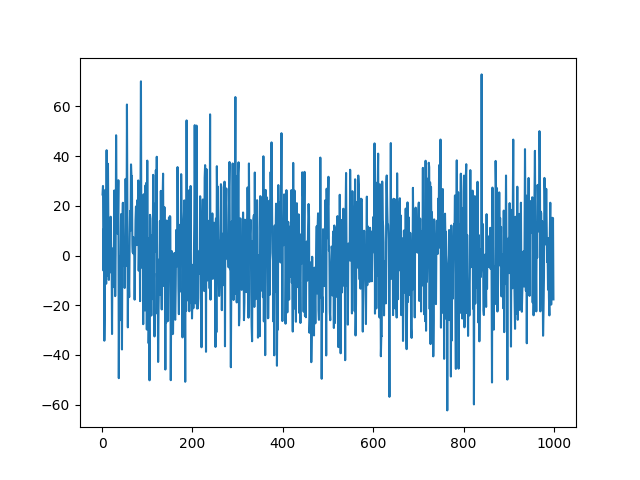

In [15]:
%matplotlib widget
noise2 = data_normal_differencing['0'] - arima_model.predict_in_sample()
plt.close()
plt.plot(noise2)
plt.show()

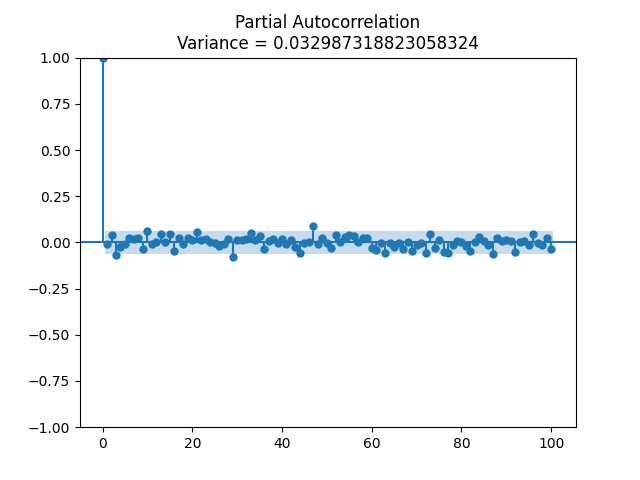

In [16]:
%matplotlib widget
plt.close()
tsaplots.plot_pacf(noise2.dropna(), lags=100)
plt.title(f"Partial Autocorrelation\nVariance = {pacf(noise2.dropna()).var()}")
plt.show()

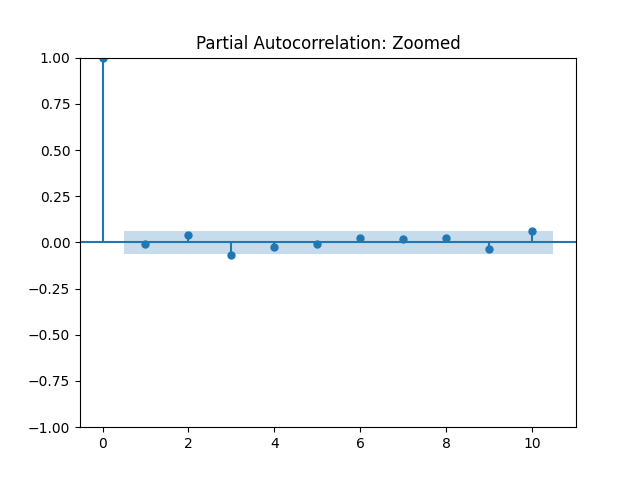

In [17]:
%matplotlib widget
plt.close()
tsaplots.plot_pacf(noise2.dropna(), lags=10)
plt.title("Partial Autocorrelation: Zoomed")
plt.show()

הפעם זה דומה יותר לרעש לבן. נשאיר את זה ככה.

In [18]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  999
Model:               SARIMAX(1, 0, 3)   Log Likelihood               -4444.621
Date:                Mon, 25 Mar 2024   AIC                           8899.243
Time:                        19:31:57   BIC                           8923.777
Sample:                             0   HQIC                          8908.568
                                - 999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   1.04e-05   9.58e+04      0.000       1.000       1.000
ma.L1         -1.9519      0.032    -60.127      0.000      -2.016      -1.888
ma.L2          0.9256      0.065     14.302      0.0

נראה שהפונקציה בחרה להשתמש במודל ארימה(1, 0, 3)

לפיכך, נשתמש במודל ארימה(1, 1, 3) עבור הנתונים המקוריים.

בנוסף, נבנה גם מודל רגרסיה ליניארית כי הנתונים בבירור ליניאריים.

## בניית המודלים

### מודל ARIMA

C:\PythonProjects\AdmissionTest\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


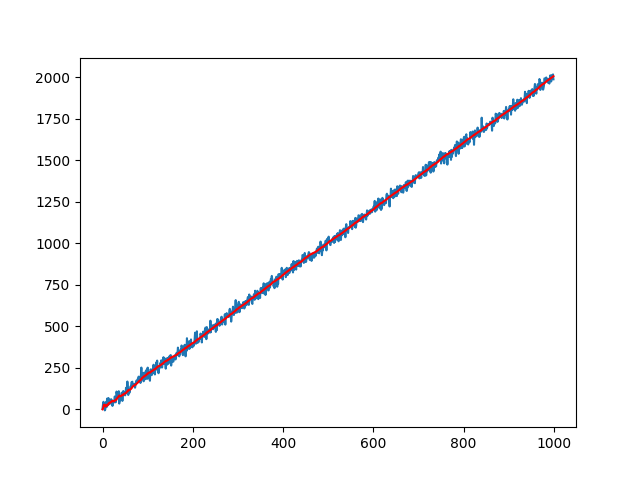

In [40]:
%matplotlib widget
arima_model = ARIMA(data_normal, order=(1, 1, 3)).fit()
arima_prediction = arima_model.predict()
plt.close()
plt.plot(data_normal)
plt.plot(arima_prediction, color='red')
plt.show()

### מודל רגרסיה ליניארית

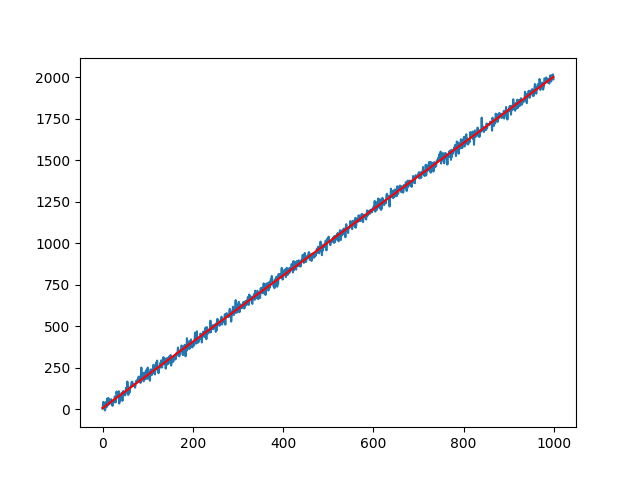

In [41]:
%matplotlib widget
X = data_normal.index.values.reshape(-1, 1)
y =  data_normal['0'].values.reshape(-1, 1)
linear_model = LinearRegression().fit(X, y)
linear_prediction = linear_model.predict(X)
plt.close()
plt.plot(data_normal)
plt.plot(linear_prediction, color='red')
plt.show()

## הערכת המודלים

### גרפים של הרעש

#### מודל ARIMA

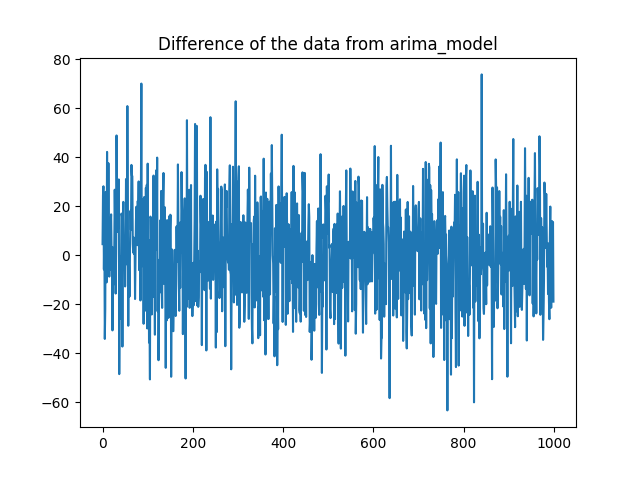

In [25]:
%matplotlib widget
arima_noise = data_normal['0'] - arima_prediction

plt.close()
plt.plot(arima_noise)
plt.title('Difference of the data from arima_model')
plt.show()

#### מודל רגרסיה ליניארית

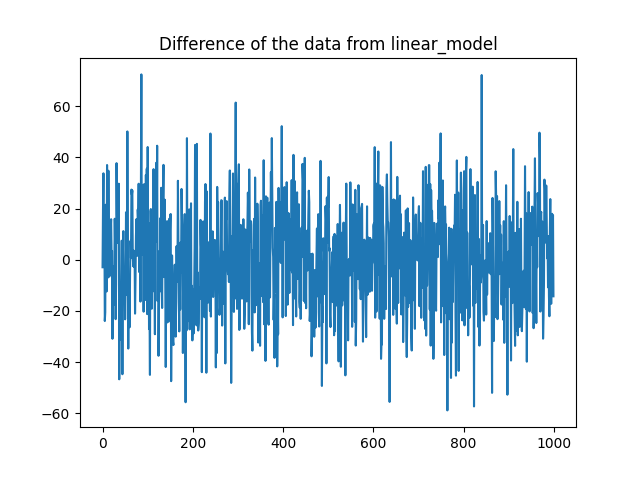

In [26]:
%matplotlib widget
linear_noise = data_normal['0'].values - linear_prediction.reshape(-1,)

plt.close()
plt.plot(linear_noise)
plt.title('Difference of the data from linear_model')
plt.show()

### סטציונריות הרעש

#### מודל ARIMA

In [27]:
result = adfuller(arima_noise.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.278721
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


#### מודל רגרסיה ליניארית

In [28]:
result = adfuller(linear_noise)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.732334
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


### תוחלת הרעש

#### מודל ARIMA

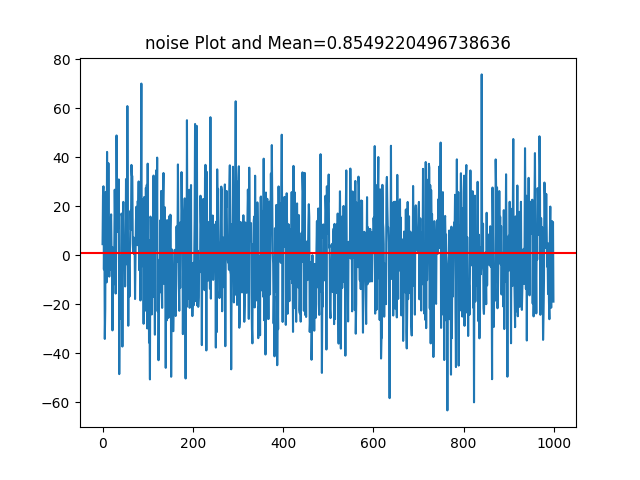

In [29]:
%matplotlib widget
plt.close()
plt.plot(arima_noise)
plt.axhline(y=arima_noise.mean(), color='red')
plt.title(f'noise Plot and Mean={arima_noise.mean()}')
plt.show()

#### מודל רגרסיה ליניארית

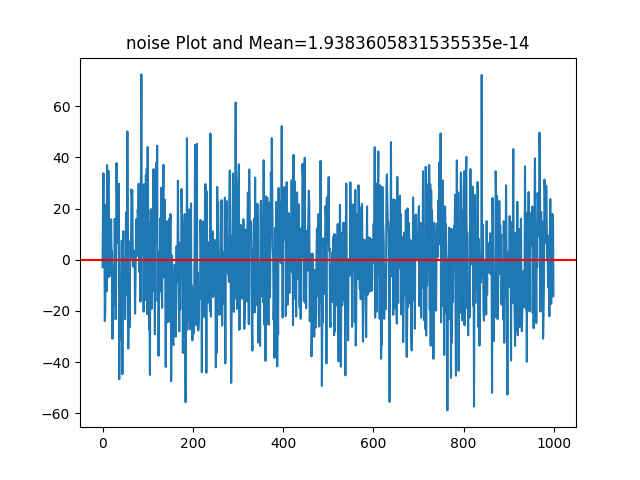

In [30]:
%matplotlib widget
plt.close()
plt.plot(linear_noise)
plt.axhline(y=linear_noise.mean(), color='red')
plt.title(f'noise Plot and Mean={linear_noise.mean()}')
plt.show()

### בחינת PACF של הרעש

#### מודל ARIMA

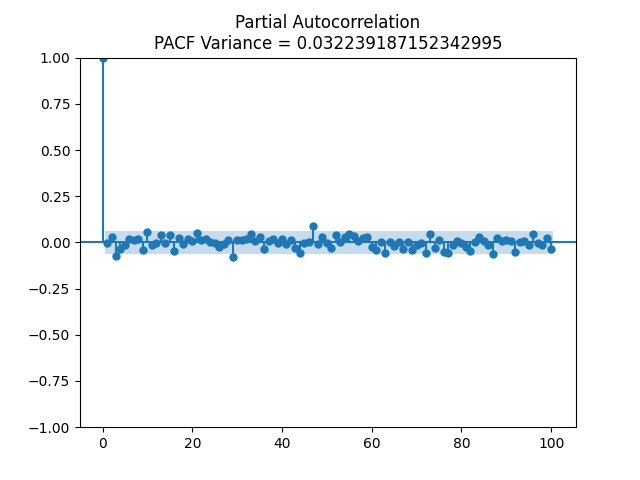

In [31]:
%matplotlib widget
plt.close()
tsaplots.plot_pacf(arima_noise, lags=100)
plt.title(f"Partial Autocorrelation\nPACF Variance = {pacf(arima_noise).var()}")
plt.show()

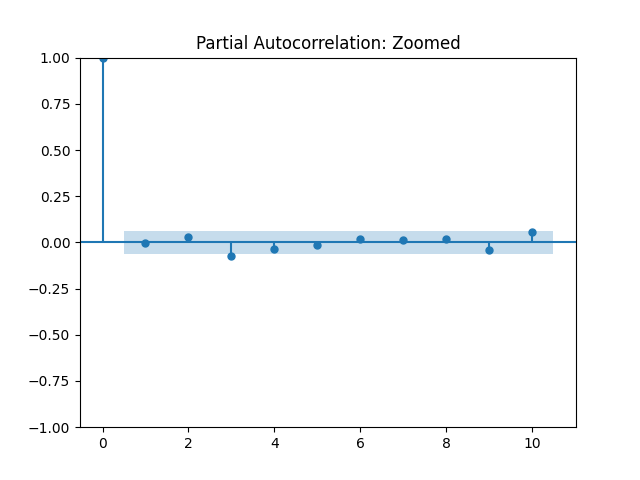

In [32]:
%matplotlib widget
plt.close()
tsaplots.plot_pacf(arima_noise, lags=10)
plt.title("Partial Autocorrelation: Zoomed")
plt.show()

#### מודל רגרסיה ליניארית

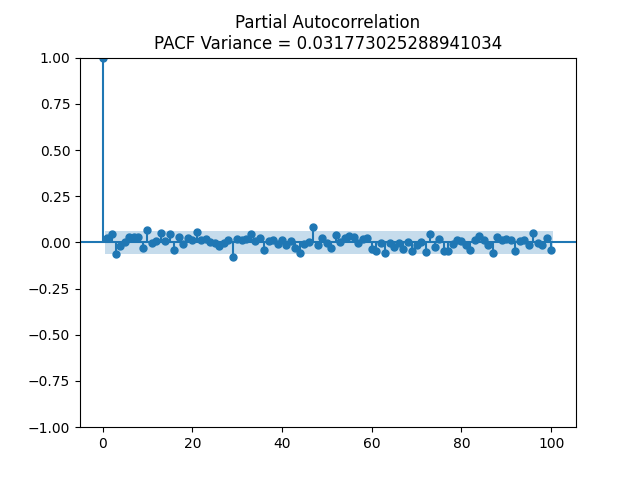

In [33]:
%matplotlib widget
plt.close()
tsaplots.plot_pacf(linear_noise, lags=100)
plt.title(f"Partial Autocorrelation\nPACF Variance = {pacf(linear_noise).var()}")
plt.show()

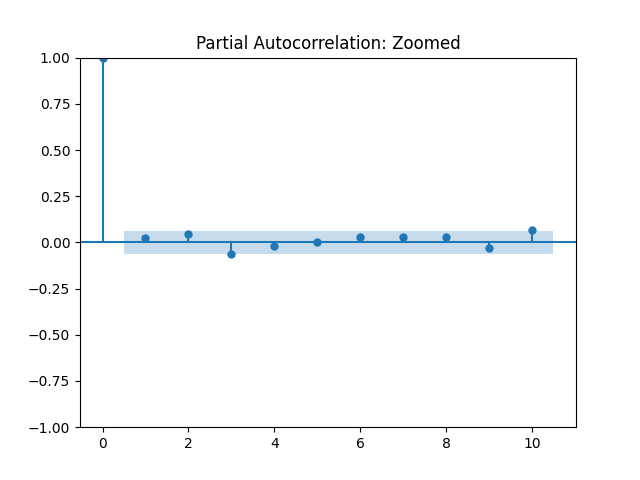

In [34]:
%matplotlib widget
plt.close()
tsaplots.plot_pacf(linear_noise, lags=10)
plt.title("Partial Autocorrelation: Zoomed")
plt.show()

### נורמה של הרעש

#### מודל ARIMA

In [35]:
print('difference metric in L^1:', abs(arima_noise).mean())
print('difference metric in L^2:', sqrt((arima_noise**2).mean()))

difference metric in L^1: 16.631160112724057
difference metric in L^2: 20.689077390188086


#### מודל רגרסיה ליניארית

In [36]:
print('difference metric in L^1:', abs(linear_noise).mean())
print('difference metric in L^2:', sqrt((linear_noise**2).mean()))

difference metric in L^1: 16.520052600299643
difference metric in L^2: 20.43379077696858


### סיכום

שני המודלים הם די טובים. ההפרשים בין המודלים לנתונים הם סטציונריים, ולכן עבור תצפיות מאוחרות, נצפה לראות:
$$
\frac{\mathrm{Model}_{t}}{\mathrm{Data}_t} \approx 1
$$
עבור שני המודלים.
מבין שניהם אני מעדיף את המודל הליניארי, כי יש בו פחות פרמטרים.

## תחזית

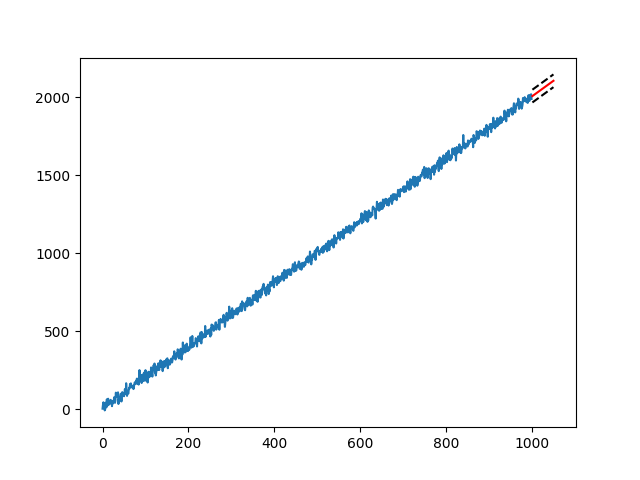

       prediction  lower_limit  upper_limit
1001  2006.174161  1965.306580  2047.041743
1002  2008.170805  1967.303223  2049.038386
1003  2010.167448  1969.299867  2051.035030
1004  2012.164092  1971.296510  2053.031673
1005  2014.160735  1973.293154  2055.028317
1006  2016.157379  1975.289797  2057.024960
1007  2018.154022  1977.286441  2059.021604
1008  2020.150666  1979.283084  2061.018247
1009  2022.147309  1981.279728  2063.014891
1010  2024.143953  1983.276371  2065.011534
1011  2026.140596  1985.273015  2067.008178
1012  2028.137240  1987.269658  2069.004821
1013  2030.133883  1989.266302  2071.001465
1014  2032.130527  1991.262945  2072.998108
1015  2034.127170  1993.259589  2074.994752
1016  2036.123814  1995.256232  2076.991395
1017  2038.120457  1997.252876  2078.988039
1018  2040.117101  1999.249519  2080.984682
1019  2042.113744  2001.246163  2082.981326
1020  2044.110388  2003.242806  2084.977969
1021  2046.107031  2005.239450  2086.974613
1022  2048.103675  2007.236093  

In [37]:
%matplotlib widget
X = np.arange(1001, 1051).reshape(-1, 1)
prediction = pd.DataFrame({'prediction': linear_model.predict(X).reshape(-1)})
prediction.index = X.reshape(-1)
prediction['lower_limit'] = prediction['prediction'] - 2 * sqrt((linear_noise**2).mean())
prediction['upper_limit'] = prediction['prediction'] + 2 * sqrt((linear_noise**2).mean())

plt.close()
plt.plot(data_normal)
plt.plot(prediction['prediction'], color='red')
plt.plot(prediction.loc[: ,'lower_limit':], color='black', linestyle='--')
plt.show()

print(prediction)

# Data_Hard.csv

## הצגת הנתונים

In [43]:
data_hard = pd.read_csv('Data_Hard.csv')
print(data_hard)

            0
0   -0.066253
1    0.323744
2    0.093955
3    0.255858
4    0.120057
..        ...
995  9.604703
996  9.569431
997  9.476205
998  9.819135
999  9.897470

[1000 rows x 1 columns]


ובאופן גרפי:

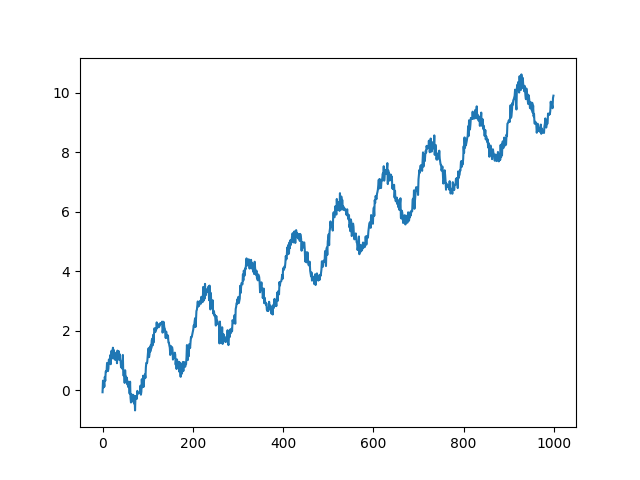

In [44]:
%matplotlib widget
plt.close()
plt.plot(data_hard)
plt.show()

## עונתיות

ניכר באופן גרפי שהנתונים חוזרים על תבנית עונתית מסוימת $10$ פעמים מבין $1000$ הזמנים הנתונים. נבדוק הפרדת עונתיות באמצעות פונקציה סטנדרטית:

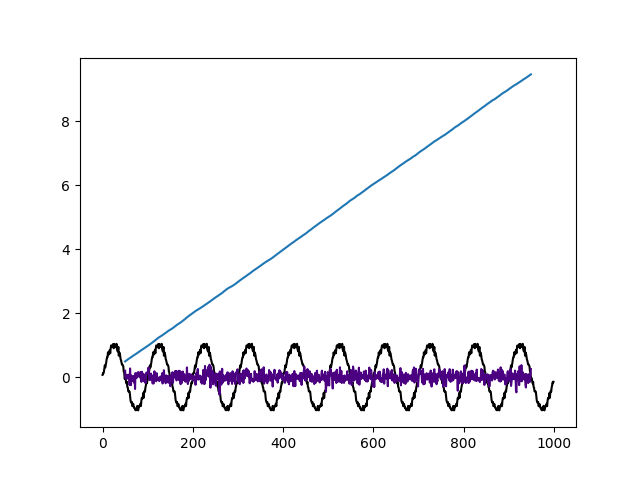

In [47]:
%matplotlib widget
decompose_result_mult = seasonal_decompose(data_hard, model="additive", period=100)

trend_data = decompose_result_mult.trend
seasonal_data = decompose_result_mult.seasonal
resid_data = decompose_result_mult.resid

plt.close()
plt.plot(trend_data)
plt.plot(seasonal_data, color='black')
plt.plot(resid_data, color='indigo')
plt.show()

נראה שההפרדה נותנת שלושה טורי זמן של אחד מהם נראה יותר פשוט לעבודה.

## סטציונריות

### טרנד

In [49]:
result = adfuller(trend_data.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.953344
p-value: 0.769899
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


### עונתיות

In [50]:
result = adfuller(seasonal_data.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.037132
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


### שארית

In [51]:
result = adfuller(resid_data.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -30.600370
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568


### סיכום

העונתיות והשארית הם סטציונאריים, והטרנד לא. מאחר שדנו בנתונים בצורה דומה לטרנד בסדרת הזמן הראשונה, אדלג על הדיון בו ואמדל אותו באמצעות רגרסיה ליניארית.

## ניתוח של השארית

כדי להציג מודל כסכום של העונתיות שהוצאנו ושל רגרסיה ליניארית, צריך להראות שהשארית מתנהגת כמו רעש.

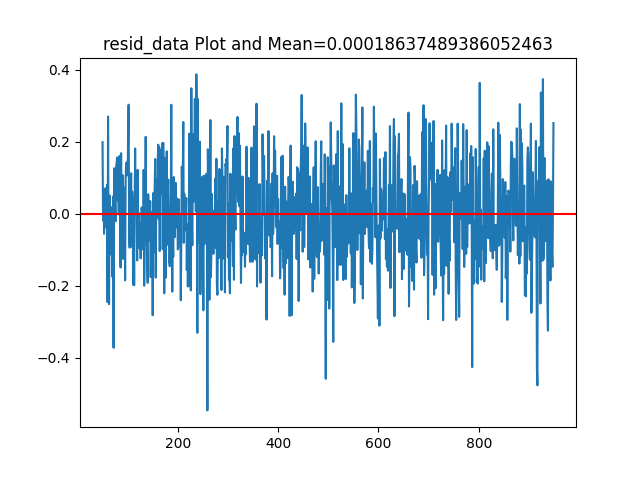

In [52]:
%matplotlib widget
plt.close()
plt.plot(resid_data)
plt.axhline(y=resid_data.mean(), color='red')
plt.title(f'resid_data Plot and Mean={resid_data.mean()}')
plt.show()

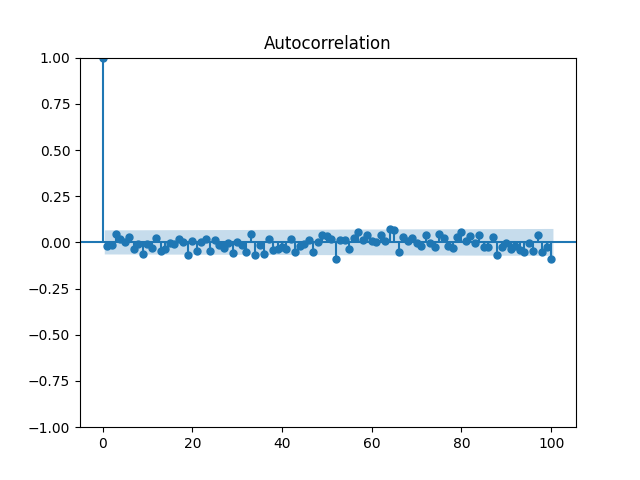

In [53]:
%matplotlib widget
plt.close()
tsaplots.plot_acf(resid_data.dropna(), lags=100)
plt.show()

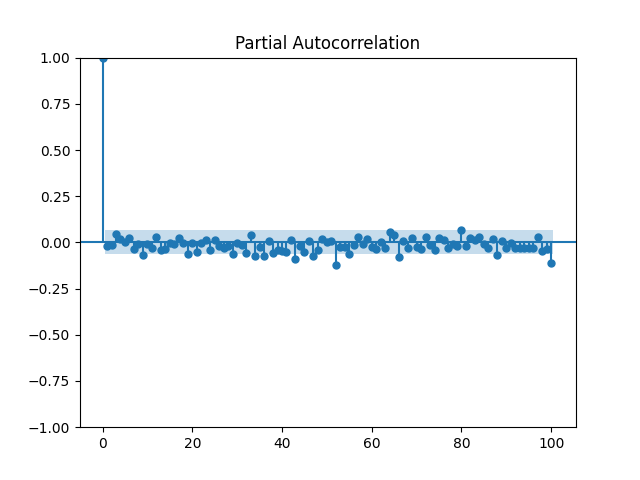

In [55]:
%matplotlib widget
plt.close()
tsaplots.plot_pacf(resid_data.dropna(), lags=100)
plt.show()

וכן אם נחשב את הנורמה של השארית ב-$L^1$ וב-$L^2$ נקבל:

In [56]:
print('difference metric in L^1:', abs(resid_data).mean())
print('difference metric in L^2:', sqrt((resid_data**2).mean()))

difference metric in L^1: 0.111301793709698
difference metric in L^2: 0.138739622444145


שזה קטן ביחס לערכים האבסולוטיים של סדרת הזמן. עם זאת נכניס את הנורמה של השארית ב-$L^2$ למודל כי היא תהווה את החלק הארי מסטיית התקן שלו.

## בניית המודל

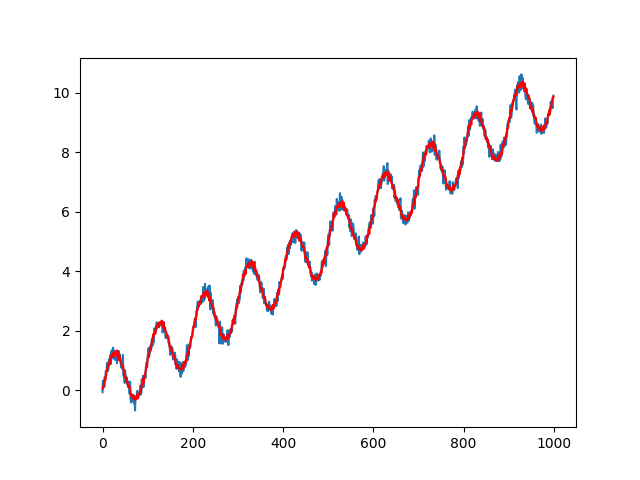

In [59]:
%matplotlib widget
class Model:
    def __init__(self, linear_data, seasonal_data, period_width, resid_std):
        X = linear_data.dropna().index.values.reshape(-1, 1)
        y =  linear_data.dropna().values.reshape(-1, 1)
        self.linear_model = LinearRegression().fit(X, y)
        self.std = (sqrt(((linear_data.dropna() - self.linear_model.predict(X).reshape(-1,))**2).mean()) 
                   + resid_std)  ## add the std from the linear regression with the std from the resid_data, which orignially results form the seasonal decomposition.
        self.period_width = period_width
        self.seasonal_period = seasonal_data[:self.period_width]

    def predict(self, X):
        linear_prediction = self.linear_model.predict(X)  # linar_prediction is done by linear regression
        seasonal_prediction = np.array([self.seasonal_period[t % self.period_width] for t in X])  # seasonal prediction is done by assuming the seasonal shape is repeated perfectly.
        prediction = linear_prediction + seasonal_prediction
        prediction = prediction.reshape(-1)
        prediction = pd.DataFrame({'prediction': prediction,
                                        'lower_limit': prediction - 2 * my_model.std,
                                        'upper_limit': prediction + 2 * my_model.std})
        prediction.index = X.reshape(-1)
        return prediction

    def plot(self, X, *,  prediction_limit_lines=True):
        prediction_plot = self.predict(X)
        plt.plot(prediction_plot['prediction'], color='red')
        if prediction_limit_lines:
            plt.plot(prediction_plot.loc[: ,'lower_limit':], color='black', linestyle='--')


my_model = Model(trend_data, seasonal_data, 100, sqrt((resid_data**2).mean()))

plt.close()
plt.plot(data_hard)
my_model.plot(data_hard.index.values.reshape(-1, 1), prediction_limit_lines=False)
plt.show()

## הערכת המודל

### גרף של הרעש

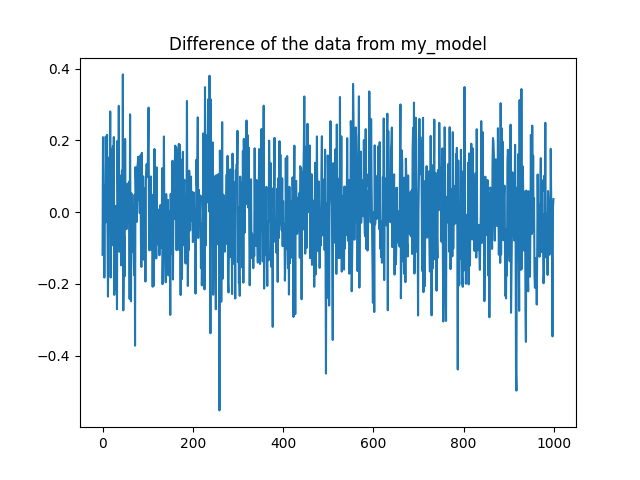

In [64]:
%matplotlib widget
prediction = my_model.predict(data_hard.index.values.reshape(-1, 1))['prediction'].values.reshape(-1,)
noise = data_hard['0'] - prediction

plt.close()
plt.plot(noise)
plt.title('Difference of the data from my_model')
plt.show()

### סטציונריות הרעש

In [66]:
result = adfuller(noise)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -32.083371
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


ולכן הרעש סטיונארי

### תוחלת של הרעש

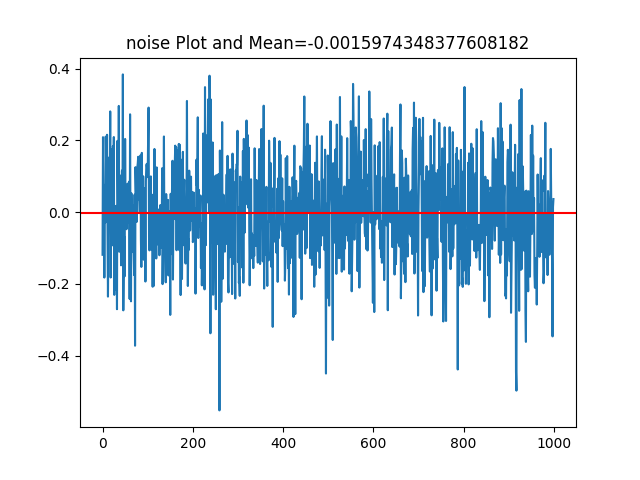

In [67]:
%matplotlib widget
plt.close()
plt.plot(noise)
plt.axhline(y=noise.mean(), color='red')
plt.title(f'noise Plot and Mean={noise.mean()}')
plt.show()

### בחינת PACF של הרעש

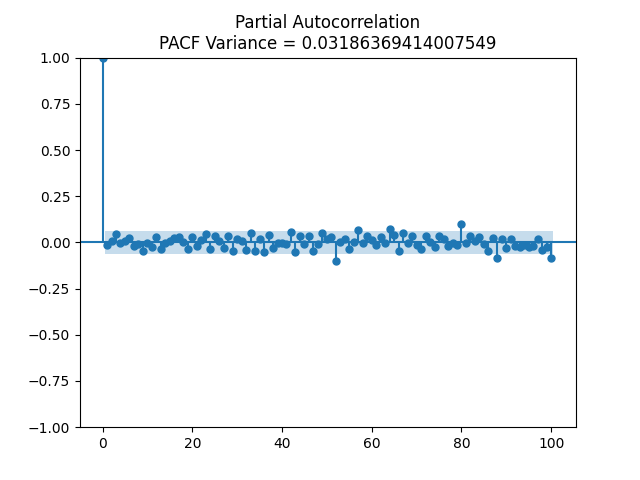

In [68]:
%matplotlib widget
from statsmodels.tsa.stattools import pacf
plt.close()
tsaplots.plot_pacf(noise, lags=100)
plt.title(f"Partial Autocorrelation\nPACF Variance = {pacf(noise).var()}")
plt.show()

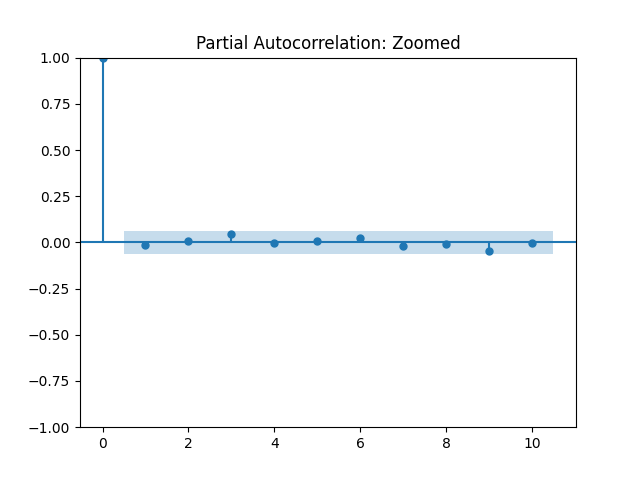

In [69]:
%matplotlib widget
plt.close()
tsaplots.plot_pacf(noise, lags=10)
plt.title("Partial Autocorrelation: Zoomed")
plt.show()

### נורמה של הרעש

In [70]:
print('difference metric in L^1:', abs(noise).mean())
print('difference metric in L^2:', sqrt((noise**2).mean()))

difference metric in L^1: 0.11198063764226779
difference metric in L^2: 0.1397425445644745


### סיכום

המודל די טוב, השארית בין מודל לנתונים שבידינו הם בבירור רעש שהתוחלת שלו אפסית. גם גודל הרעש הוא קטן יחסית לנתונים עבור $t$ גדולים ובנוסף הרעש הוא סטציונארי באופן היסטורי, ולכן ניתן להעריך שהמודל יתן חיזוי מדויק. 

## תחזית

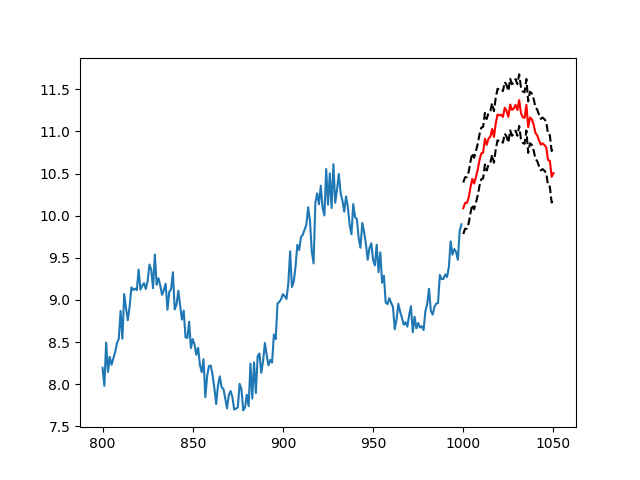

      prediction  lower_limit  upper_limit
1000   10.088136     9.782402    10.393871
1001   10.150382     9.844648    10.456117
1002   10.152681     9.846946    10.458416
1003   10.215393     9.909659    10.521128
1004   10.337873    10.032138    10.643607
1005   10.437270    10.131535    10.743004
1006   10.381175    10.075440    10.686910
1007   10.457611    10.151876    10.763345
1008   10.545983    10.240248    10.851717
1009   10.659786    10.354051    10.965520
1010   10.739105    10.433370    11.044839
1011   10.748051    10.442317    11.053786
1012   10.913599    10.607864    11.219334
1013   10.841712    10.535977    11.147447
1014   10.916027    10.610293    11.221762
1015   10.937592    10.631858    11.243327
1016   11.029486    10.723751    11.335220
1017   10.934400    10.628665    11.240134
1018   11.093090    10.787355    11.398824
1019   11.200549    10.894814    11.506283
1020   11.188838    10.883103    11.494572
1021   11.198106    10.892372    11.503841
1022   11.1

In [71]:
%matplotlib widget
X = np.arange(1000, 1051).reshape(-1, 1)
prediction =  my_model.predict(X)

plt.close()
plt.plot(data_hard[800:])
my_model.plot(X, prediction_limit_lines=True)
plt.show()

print(prediction)